<a href="https://colab.research.google.com/github/icosahedron10/ieee-cis-fraud-detection/blob/main/IEEE_CIS_FraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IEEE-CIS Fraud Detection

The IEEE-CIS Fraud Detection competition was held on Kaggle in 2019 and was sponsored by the Institute of Electrical and Electronics Engineers Computational Intelligence Society (IEEE-CIS). The dataset used for the competition was provided by a financial institution and contained transaction data for credit card usage. The goal of the competition was to build a machine learning model that could accurately detect fraudulent transactions in this highly imbalanced dataset. The competition was widely participated in by the machine learning community, and the results showed the power of modern machine learning techniques for addressing the challenge of fraud detection. The dataset and the competition continue to be a popular source of inspiration and learning for those interested in this field.

In this Jupyter notebook, we explore the use of Synthetic Minority Over-sampling Technique (SMOTE) and XGBoost for classifying fraudulent transactions in the IEEE-CIS dataset. Fraud detection is a crucial task in the financial industry as it helps prevent significant losses. However, traditional methods of fraud detection can be easily fooled by the imbalanced nature of fraud data, where the number of fraud cases is usually much lower than the number of non-fraud cases.

SMOTE is a popular method for handling imbalanced data by creating synthetic samples of the minority class (in this case, fraud). By oversampling the minority class, SMOTE helps balance the distribution of the target variable, making the model more robust to imbalanced data.

In this project, we use a combination of SMOTE and XGBoost to address the challenge of detecting fraud in a highly imbalanced dataset. SMOTE helps to balance the distribution of the target variable by generating synthetic samples of the minority class; on the other hand, XGBoost, is a well-regarded machine learning algorithm known for its high accuracy and ability to process large datasets. By utilizing both SMOTE and XGBoost, this project aims to provide a practical demonstration of the capabilities of these techniques for fraud detection. The results of this project will serve as an introductory example of a very rich field of active research in the area of fraud detection



In [1]:
import warnings
warnings.filterwarnings('ignore')
!pip install ydata_profiling
!pip install scikit.optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as npy
from ydata_profiling import ProfileReport
from matplotlib import pyplot as plt
import seaborn as sbn

import tensorflow as tf
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from skopt import BayesSearchCV
from skopt.space import Integer, Real
import xgboost as xgb

The data we read in will be nearly two gigabytes, so we will use the following function to reduce the size of these files as much as possible. The function will do this by looking at the relative size of each column and reducing the number of bytes reserved to that number to the minimum required.

In [3]:
def reduce_mem_usage(df):
    # For each column, reduce dataype to minimum required
    # goal: Reduce memory usage        
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object and col_type != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > npy.iinfo(npy.int8).min and c_max < npy.iinfo(npy.int8).max:
                    df[col] = df[col].astype(npy.int8)
                elif c_min > npy.iinfo(npy.int16).min and c_max < npy.iinfo(npy.int16).max:
                    df[col] = df[col].astype(npy.int16)
                elif c_min > npy.iinfo(npy.int32).min and c_max < npy.iinfo(npy.int32).max:
                    df[col] = df[col].astype(npy.int32)
                elif c_min > npy.iinfo(npy.int64).min and c_max < npy.iinfo(npy.int64).max:
                    df[col] = df[col].astype(npy.int64)  
            else:
                if c_min > npy.finfo(npy.float16).min and c_max < npy.finfo(npy.float16).max:
                    df[col] = df[col].astype(npy.float16)
                elif c_min > npy.finfo(npy.float32).min and c_max < npy.finfo(npy.float32).max:
                    df[col] = df[col].astype(npy.float32)
                else:
                    df[col] = df[col].astype(npy.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
train_transaction = pd.read_csv('train_transaction.csv')
train_transaction = reduce_mem_usage(train_transaction)
print(train_transaction.shape)

Memory usage of dataframe is 1775.15 MB
Memory usage after optimization is: 487.16 MB
Decreased by 72.6%
(590540, 394)


In [5]:
test_transaction = pd.read_csv('test_transaction.csv')
test_transaction = reduce_mem_usage(test_transaction)
print(test_transaction.shape)

Memory usage of dataframe is 1519.24 MB
Memory usage after optimization is: 425.24 MB
Decreased by 72.0%
(506691, 393)


We can see this memory reduction was significant. In the case of the following datasets, the columns are mostly categorical variables and do not take advantage of the past function. Lukily, however, they are relatively small files.

In [6]:
train_identity = pd.read_csv('train_identity.csv')
print(train_identity.shape)

(144233, 41)


In [7]:
test_identity = pd.read_csv('test_identity.csv')
print(test_identity.shape)

(141907, 41)


Now that our datasets are loaded in, we can now take advantage of the feature they have in common: TransactionID. We will use the merge() function in Pandas to create our full dataset by combining all relavent identifying information about the purchaser with each transaction in the transactions dataset. We are told there are records in the transactions dataset for which there is no identifying information, so we will left-join as to keep all transactions. We can see below that the resulting dataset is nearly 600,000 records, each with 433 features and one response. 

In [8]:
train = pd.merge(train_transaction, train_identity, how='left')
print(train.shape)

(590540, 434)


In [9]:
test = pd.merge(test_transaction, test_identity, how='left')
print(test.shape)

(506691, 433)


In [10]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


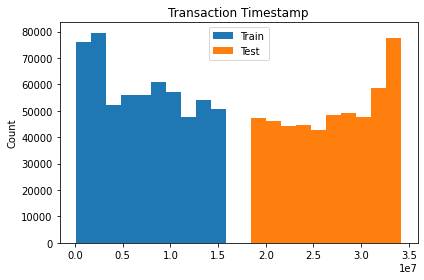

In [11]:
plt.hist(train['TransactionDT'], label='Train')
plt.hist(test['TransactionDT'], label='Test')
plt.ylabel('Count')
plt.title('Transaction Timestamp')
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
train.duplicated().sum()

0

From the code above, we can see that we have no duplicate records. Now, we will move into the process of cleaning this data. As a first note, we will find out how many missing records each data column has. 

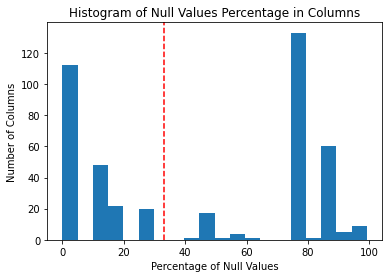

In [13]:
null_values = train.isnull().mean() * 100

# Plot the histogram
plt.hist(null_values, bins=20)
plt.xlabel("Percentage of Null Values")
plt.ylabel("Number of Columns")
plt.title("Histogram of Null Values Percentage in Columns")
plt.axvline(x=33, color='red', linestyle='dashed')
plt.show()

In the above plot, we have visualized the percentage of null values in each column as a histogram. This is because the next step in our process is to prune columns from our dataset with too many null values. Referencing the plot above again, the red line plotted represents the proposed value after which we would not accept a column. Specifically, if we need to impute more than 33% of the data in a column, we have to accept that we are not going to gain much understanding from it. This value is the largest harmonic that I will accept in this regard (1/5 or 1/4 are preferred, etc).

Below, we will begin preprocessing by pruning those columns plotted above the red line. That is, we will drop each column with more than 33% missing data.

In [14]:
y = train['isFraud']

In [15]:
to_clean = pd.concat([train.drop(columns=['isFraud', 'TransactionID']),
                      test.drop(columns='TransactionID')])
print(to_clean.shape)

# Dropping columns with more than 25% missing values 
mv = to_clean.isnull().sum()/len(to_clean)
to_clean = to_clean.drop(columns=mv[mv>0.65].index)
print(to_clean.shape)

(1097231, 470)
(1097231, 224)


We can see from the output above that we kept 224 columns of the 470 that we started with. That is a column retention rate of about 48%.

With the columns that we kept, we will now perform imputation to clean up all of the null values. For the numerical columns, we will use median imputation, and we will use mode imputation for all of the categorical columns. After cleaning these independently, we will concatenate them back together and move on to the next steps of preprocessing.

In [16]:
numericals_to_clean = to_clean.select_dtypes(include=npy.number)
categoricals_to_clean = to_clean.select_dtypes(exclude=npy.number)

# Median imputation on numericals
meadian_imputer = SimpleImputer(missing_values=npy.nan, strategy='median')
numericals = pd.DataFrame(meadian_imputer.fit_transform(numericals_to_clean), 
                          columns=numericals_to_clean.columns)

# Mode imputation on categoricals
mode_imputer = SimpleImputer(missing_values=npy.nan, strategy='most_frequent')
categoricals = pd.DataFrame(mode_imputer.fit_transform(categoricals_to_clean),
                      columns=categoricals_to_clean.columns)

# Concatinating numericals and categoricals
is_clean = pd.concat([numericals, categoricals], axis=1)

In [17]:
is_clean.isna().sum().sum()

0

Next, we will use one-hot encoding on the categorical variables to get a sparse matrix for use in XGBoost later. From the output below, we can see that our test and training set comine for nearly 1.1 million rows and that our data set contains 290 columns after using OHE.

In [18]:
is_encoded = pd.get_dummies(is_clean, drop_first=True)
print(is_encoded.shape)

(1097231, 290)


Below, we separate the dataframe 'is_encoded' back into its training and testing counterparts. We do this by taking the length of our y training dataset and removing as many records from 'is_encoded' to create the training set, and what remains is the test set.

In [19]:
X = is_encoded.iloc[:y.size]
print(X.shape)
X_test = is_encoded.iloc[y.size:]
print(X_test.shape)

(590540, 290)
(506691, 290)


Because we know that the training and testing datasets are separated in time such that all of the testing transactions happen after the training set, we will use a stratified sampling techinique to create our validation set by first ordering our training set by the timedelta column and then taking the first 70% of the records as the training set. This will leave the last 30% of the records with respect to the time delta column for the validation set, thereby simulating the testing set happening later in time.

In [20]:

# Time-based train validation splitting with 20% data in validation set
X.sort_values('TransactionDT', inplace=True)
splitting_index = int(0.7*len(X))
X_train = X.iloc[:splitting_index].values
X_val = X.iloc[splitting_index:].values
y_train = y.iloc[:splitting_index].values
y_val = y.iloc[splitting_index:].values
X_test = X_test.values

We will also carry along a copy of the full training set for use in training the final XGBoost model later on. This temp dataset will be preprocessed along with the others, but we will not remove any records from this temp record as we did with the training set above.

In [21]:
X_temp = X
y_temp = y

In [22]:
# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_temp = scaler.transform(X_temp)

# Class imbalance check
pd.value_counts(y_train)

0    398840
1     14538
dtype: int64

We can see from the output above that our dataset is very heavily imbalanced towards 'No_fraud', which means that any classifier we use to identify fraud will have a hard time not labeling each validation entry as 'No_fraud'. We will use Synthetic Minority Over-sampling Technique (SMOTE) to balance the class distribution between 'Fraud' and 'No_fraud' prior to training this model in hopes of aiding that model at detecting fraud, which is our ultimate goal.

In [23]:
# Applying SMOTE to deal with the class imbalance by oversampling
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)
X_temp, y_temp = smote.fit_resample(X_temp, y_temp)
print(X_train.shape, y_train.shape)
print(X_train.shape, y_train.shape)
pd.value_counts(y_train)

(797680, 290) (797680,)
(797680, 290) (797680,)


0    398840
1    398840
dtype: int64

In [24]:
submission = pd.DataFrame({'TransactionID':test.TransactionID})

At this point the notebook is using too much memory. These delete commands serve to clear the used memory in order to not cause stack overflow. In a future version, these delete commands will come when the dataset is no longer going to be used.

In [25]:
del is_clean
del is_encoded
del numericals
del categoricals
del train
del test

Below, we define functions to optimize the hyperparameters of an XGBoost model within a reasonable hyperparameter space. We use Bayesian search, we use 'recall' on the validation set as the value to maximize, and 5-fold cross-validation to find the optimal hyperparameters. Then, we will use these optimal values to train another XGBoost on the entire training dataset.  

In [26]:
space = {
    'max_depth': Integer(5, 9),
    'learning_rate': Real(10**-5, 10**0, prior='log-uniform'),
    'n_estimators': Integer(50, 200),
    'min_child_weight': Integer(2, 100),
    'gamma': Real(10**-5, 10**0, prior='log-uniform'),
    'subsample': Real(10**-5, 10**0, prior='log-uniform'),
    'reg_lambda': Real(10**-7, 10**-2, prior='log-uniform'),
    'reg_alpha': Real(10**-7, 10**-2, prior='log-uniform')
}

# Define the XGBoost model and the search strategy, n_jobs sets number of threads used -1 is all
xgb_model = xgb.XGBClassifier(objective = 'binary:logistic', tree_method = 'gpu_hist', scoring = 'recall')
bayes_search = BayesSearchCV(xgb_model, search_spaces=space, n_iter=25, cv=5, random_state=42)

# Fit the model and find the best hyperparameters
bayes_search.fit(X_train, y_train)

# Evaluate the model on the test set
score = bayes_search.score(X_val, y_val)

# Print the best hyperparameters and test accuracy
print("Best hyperparameters: ", bayes_search.best_params_)
print("Test accuracy: ", score)

Best hyperparameters:  OrderedDict([('gamma', 1.0), ('learning_rate', 1.0), ('max_depth', 5), ('min_child_weight', 37), ('n_estimators', 137), ('reg_alpha', 0.0005740245035946004), ('reg_lambda', 0.01), ('subsample', 0.0017042109417371252)])
Test accuracy:  0.885240627222542


In [27]:
# Train a new XGBoost model using the best hyperparameters on the training set
best_params = bayes_search.best_params_
model = xgb.XGBClassifier(objective = 'binary:logistic',
                          tree_method = 'gpu_hist',
                          scoring = 'recall',
                          max_depth=best_params['max_depth'],
                          learning_rate=best_params['learning_rate'],
                          n_estimators=best_params['n_estimators'],
                          subsample=best_params['subsample'],
                          gamma=best_params['gamma'],
                          min_child_weight=best_params['min_child_weight'],
                          reg_alpha=best_params['reg_alpha'],
                          reg_lambda=best_params['reg_lambda'])
model.fit(X_temp, y_temp)

XGBClassifier(gamma=1.0, learning_rate=1.0, max_depth=5, min_child_weight=37,
              n_estimators=137, reg_alpha=0.0005740245035946004,
              reg_lambda=0.01, scoring='recall',
              subsample=0.0017042109417371252, tree_method='gpu_hist')

In [28]:
# Predict the classes on the validation data
y_pred = model.predict(X_val)

# Convert the predicted classes from binary to integer (0 or 1)
y_pred_int = npy.round(y_pred).astype(int)

# Create a confusion matrix from the predicted and actual classes
cm = confusion_matrix(y_val, y_pred_int)

print(cm)

[[156972  14065]
 [  2976   3149]]


Above, we take the optimal hyperparameters from our Bayesian search above and train another XGBoost model using the entire train dataset. With this model, we make predictions below for the test set and set up the dataframe 'submission' to be saved to .csv for testing on Kaggle.com.

In [29]:
predictions = bayes_search.predict_proba(X_test)
submission['isFraud'] = predictions[:, 1]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa1878cba60>,
      dtype=object)

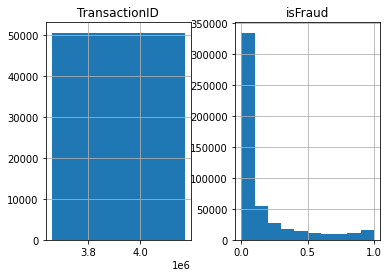

In [30]:
submission.hist()